# Imports

In [2]:
# Imports
import os
import cv2
import glob
import h5py
import time
import random
import urllib
import pickle
import argparse

import numpy as np
import nibabel as nib
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable as V
from torchvision import transforms as trn

from scipy.stats import spearmanr
import seaborn as sns

# Functions

In [16]:
# @title Load mat files
def loadmat(matfile):
  """Function to load .mat files.
  Parameters
  ----------
  matfile : str
      path to `matfile` containing fMRI data for a given trial.
  Returns
  -------
  dict
      dictionary containing data in key 'vol' for a given trial.
  """
  try:
    f = h5py.File(matfile)
  except (IOError, OSError):
    return sio.loadmat(matfile)
  else:
    return {name: np.transpose(f.get(name)) for name in f.keys()}

In [17]:
# RDM comparison functions
def RSA_spearman(rdm1,rdm2):
  """
  computes and returns the spearman correlation between lower triangular
  part of the input rdms. We only need to compare either lower or upper
  triangular part of the matrix as RDM is symmetric
  """
  # get lower triangular part of the RDM1
  lt_rdm1 = get_lowertriangular(rdm1)
  # get lower triangular part of the RDM1
  lt_rdm2 = get_lowertriangular(rdm2)
  # return Spearman's correlation between lower triangular part of rdm1 & rdm2
  return spearmanr(lt_rdm1, lt_rdm2)[0]

def get_lowertriangular(rdm):
  """
  returns lower triangular part of the matrix
  """
  num_conditions = rdm.shape[0]
  return rdm[np.tril_indices(num_conditions, -1)]

In [19]:
def spearman_across_sessions(rdm1, rdm2):
    '''
    @param: MEG RDMs of all time points for 1 subject from 2 sessions
    returns a list of spearman correlation between 2 sessions for all the timepoints 
    '''
    spearman_corr = []
    timepoints = np.arange(-100, 1220, 20)

    for timepoint in timepoints:
        #Load RDM at a given timepoint
        # +100 as the RDMs provided are from -100ms to 1000ms after the stimulus onset
        RDM1 = np.array(rdm1[timepoint+100])
        RDM2 = np.array(rdm2[timepoint+100])

        corr = RSA_spearman(RDM1, RDM2) # calculate the spearman correlation between RDMs from 2 sessions

        spearman_corr.append(corr)
    
    return spearman_corr

# Exploring MEG RDMs difference between sessions across subjects

In [20]:
# Load MEG RDMs for each time point for all subjects all sessions
MEG_RDMs = loadmat("/Users/momoqyan1/Documents/NMA/data/MEG_decoding_RDMs.mat")['MEG_decoding_RDMs']
print(MEG_RDMs.shape)

(16, 2, 1301, 92, 92)


In [21]:
# calculate spearman correlation between sessions across subjects
spearman_across_sub = []

for MEG_RDM_sub in MEG_RDMs:
    spearman_corr = []
    MEG_RDM_session1 = MEG_RDM_sub[0]
    MEG_RDM_session2 = MEG_RDM_sub[1]
    spearman_corr = spearman_across_sessions(MEG_RDM_session1, MEG_RDM_session2)
    spearman_across_sub.append(spearman_corr)

print(np.array(spearman_across_sub).shape)

(16, 66)


In [10]:
# for error checking purposes
for idx, spearman_corr in enumerate(spearman_across_sub):
    print(f'Subject {idx+1}: Spearman correlations = {spearman_corr}')

Subject 1: Spearman correlations = [np.float64(-0.03699955551188456), np.float64(-0.006023379114797791), np.float64(0.0076833221157604666), np.float64(0.02164197114424535), np.float64(0.0038268857663966284), np.float64(0.0032231543573299853), np.float64(-0.013560786558325261), np.float64(0.016899167268264688), np.float64(-0.007487990403933549), np.float64(0.18816185596635193), np.float64(0.37910778754297514), np.float64(0.4015952561566335), np.float64(0.2628804471207084), np.float64(0.17688102201782724), np.float64(0.21905173411536233), np.float64(0.2581873171136257), np.float64(0.1819378610687216), np.float64(0.18999746437324133), np.float64(0.19555122273225384), np.float64(0.18221468145599495), np.float64(0.18282550244175966), np.float64(0.16847255689711343), np.float64(0.11587200765559168), np.float64(0.08162520672621679), np.float64(0.1587403705195464), np.float64(0.08968417678717698), np.float64(0.10525525502215825), np.float64(0.07178159758705795), np.float64(0.03517145641675376)

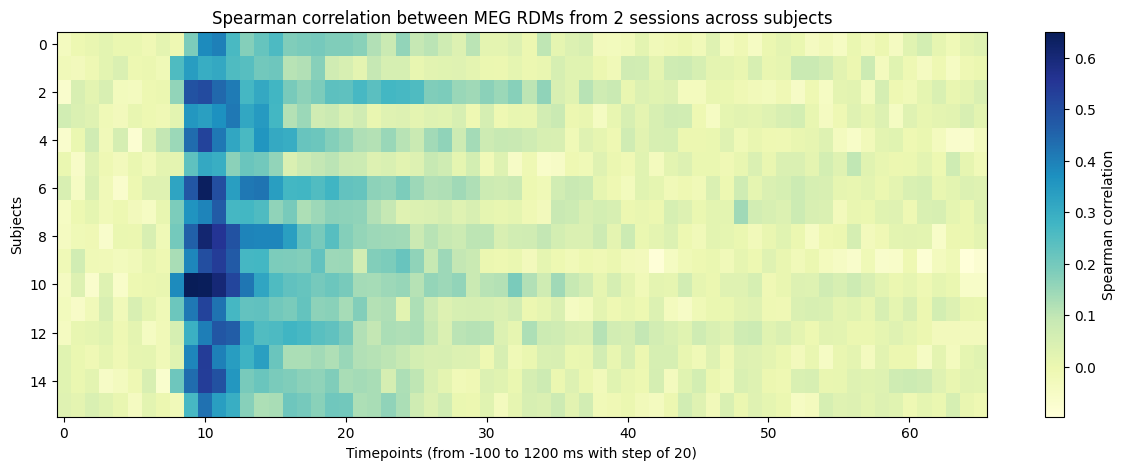

In [11]:
plt.figure(figsize=(15,5))
plt.imshow(spearman_across_sub, cmap='YlGnBu', aspect='auto')  # Plot the heatmap
plt.xlabel('Timepoints (from -100 to 1200 ms with step of 20)')
plt.ylabel('Subjects')
plt.title("Spearman correlation between MEG RDMs from 2 sessions across subjects")

cbar = plt.colorbar()
cbar.set_label('Spearman correlation')
plt.show()

# Compare fMRI RDMs across brain regions

In [23]:
fMRI_file = '/Users/momoqyan1/Documents/NMA/data/92_Image_Set/target_fmri.mat'  # path of fMRI RDM file
fMRI_RDMs = loadmat(fMRI_file)  # load the fMRI RDMs
print(fMRI_RDMs.keys())
print(fMRI_RDMs['EVC_RDMs'].shape)
print(fMRI_RDMs['IT_RDMs'].shape)

dict_keys(['EVC_RDMs', 'IT_RDMs'])
(15, 92, 92)
(15, 92, 92)


In [24]:
# averaging between subjects
RDM_EVC = np.array(fMRI_RDMs['EVC_RDMs'].mean(axis=0)) 
RDM_IT = np.array(fMRI_RDMs['IT_RDMs'].mean(axis=0))

# set upper triangular values to NaN
RDM_EVC[np.triu_indices(RDM_EVC.shape[0], 1)] = np.nan
RDM_IT[np.triu_indices(RDM_IT.shape[0], 1)] = np.nan

# initialize difference matrix 
difference_matrix = np.zeros(RDM_EVC.shape)

# calculate difference between EVC and IT for 
for i in range(RDM_EVC.shape[0]):
    for j in range(RDM_EVC.shape[1]):
        difference_matrix[i, j] = RDM_EVC[i, j] - RDM_IT[i, j]

print(difference_matrix.shape)

(92, 92)


Text(0, 0.5, 'Stimuli')

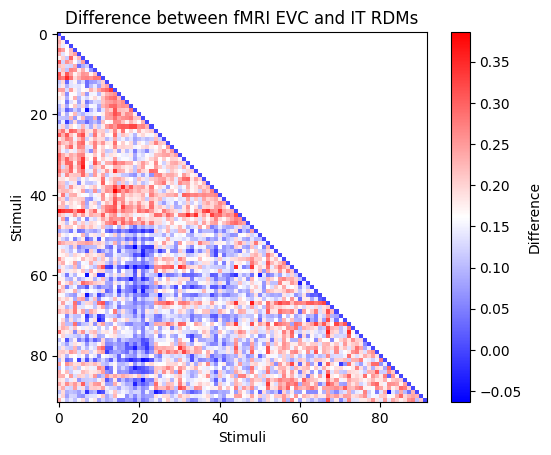

In [25]:
plt.imshow(difference_matrix, cmap="bwr")
plt.title('Difference between fMRI EVC and IT RDMs')
cbar = plt.colorbar()
cbar.set_label('Difference')
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")